# Проектная работа по модулю “Построение моделей”

решить задачу бинарной классификации на большом признаковом множестве для датасета банка Santader (https://www.santanderbank.com/us/personal)

In [30]:
import numpy as np
from numpy import array
import pandas as pd
import collections
import math

import xgboost
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew

from pandas.plotting import scatter_matrix

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Binarizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA, KernelPCA

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

plt.style.use('ggplot')

1. Загрузить данные

In [2]:
data_train=pd.read_csv('train.csv')

In [3]:
data_test=pd.read_csv('test.csv')

In [4]:
sample_submission=pd.read_csv('sample_submission.csv')

2. Провести описательный анализ предложенных данных

In [5]:
data_train.head(10)

ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   
3   8     2     37                 0.0                    195.0   
4  10     2     39                 0.0                      0.0   
5  13     2     23                 0.0                      0.0   
6  14     2     27                 0.0                      0.0   
7  18     2     26                 0.0                      0.0   
8  20     2     45                 0.0                      0.0   
9  23     2     25                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   
5                      0.0                      0.0                      0.0   
6                      0.0                      0.0                      0.0   
7                      0.0                      0.0                      0.0   
8                      0.0                      0.0                      0.0   
9                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3   ...    \
0                      0.0                      0.0   ...     
1                      0.0                      0.0   ...     
2                      0.0                      0.0   ...     
3                      0.0                      0.0   ...     
4                      0.0                      0.0   ...     
5                      0.0                      0.0   ...     
6                      0.0                      0.0   ...     
7                      0.0                      0.0   ...     
8                      0.0                      0.0   ...     
9                      0.0                      0.0   ...     

   saldo_medio_var33_hace2  saldo_medio_var33_hace3  saldo_medio_var33_ult1  \
0                      0.0                      0.0                     0.0   
1                      0.0                      0.0                     0.0   
2                      0.0                      0.0                     0.0   
3                      0.0                      0.0                     0.0   
4                      0.0                      0.0                     0.0   
5                      0.0                      0.0                     0.0   
6                      0.0                      0.0                     0.0   
7                      0.0                      0.0                     0.0   
8                      0.0                      0.0                     0.0   
9                      0.0                      0.0                     0.0   

   saldo_medio_var33_ult3  saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   
3                     0.0                      0.0                      0.0   
4                     0.0                      0.0                      0.0   
5                     0.0                      0.0                      0.0   
6                     0.0                      0.0                      0.0   
7                     0.0                      0.0                      0.0   
8                     0.0                      0.0                      0.0   
9                     0.0     

In [6]:
data_train.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Data columns (total 371 columns):
ID                               76020 non-null int64
var3                             76020 non-null int64
var15                            76020 non-null int64
imp_ent_var16_ult1               76020 non-null float64
imp_op_var39_comer_ult1          76020 non-null float64
imp_op_var39_comer_ult3          76020 non-null float64
imp_op_var40_comer_ult1          76020 non-null float64
imp_op_var40_comer_ult3          76020 non-null float64
imp_op_var40_efect_ult1          76020 non-null float64
imp_op_var40_efect_ult3          76020 non-null float64
imp_op_var40_ult1                76020 non-null float64
imp_op_var41_comer_ult1          76020 non-null float64
imp_op_var41_comer_ult3          76020 non-null float64
imp_op_var41_efect_ult1          76020 non-null float64
imp_op_var41_efect_ult3          76020 non-null float64
imp_op_var41_ult1                76020 non-null float64


In [ ]:
#попущенных значений нет

In [15]:
#в дальнейшем применим уменьшиние размерности 
data_train.shape

(76020, 371)

In [7]:
data_train.describe()

ID           var3         var15  imp_ent_var16_ult1  \
count   76020.000000   76020.000000  76020.000000        76020.000000   
mean    75964.050723   -1523.199277     33.212865           86.208265   
std     43781.947379   39033.462364     12.956486         1614.757313   
min         1.000000 -999999.000000      5.000000            0.000000   
25%     38104.750000       2.000000     23.000000            0.000000   
50%     76043.000000       2.000000     28.000000            0.000000   
75%    113748.750000       2.000000     40.000000            0.000000   
max    151838.000000     238.000000    105.000000       210000.000000   

       imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
count             76020.000000             76020.000000   
mean                 72.363067               119.529632   
std                 339.315831               546.266294   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               12888.030000             21024.810000   

       imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
count             76020.000000             76020.000000   
mean                  3.559130                 6.472698   
std                  93.155749               153.737066   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max                8237.820000             11073.570000   

       imp_op_var40_efect_ult1  imp_op_var40_efect_ult3      ...       \
count             76020.000000             76020.000000      ...        
mean                  0.412946                 0.567352      ...        
std                  30.604864                36.513513      ...        
min                   0.000000                 0.000000      ...        
25%                   0.000000                 0.000000      ...        
50%                   0.000000                 0.000000      ...        
75%                   0.000000                 0.000000      ...        
max                6600.000000              6600.000000      ...        

       saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
count             76020.000000             76020.000000   
mean                  7.935824                 1.365146   
std                 455.887218               113.959637   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               50003.880000             20385.720000   

       saldo_medio_var33_ult1  saldo_medio_var33_ult3  \
count            76020.000000            76020.000000   
mean                12.215580                8.784074   
std                783.207399              538.439211   
min                  0.000000                0.000000   
25%                  0.000000                0.000000   
50%                  0.000000                0.000000   
75%                  0.000000                0.000000   
max             138831.630000            91778.730000   

       saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
count             76020.000000             76020.000000   
mean                 31.505324                 1.858575   
std                2013.125393               147.786584   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max              438329.220000             24650.010000   

       saldo_medio_var44_ult1  saldo_medio_var44_ult3       

In [8]:
data_train["TARGET"].value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

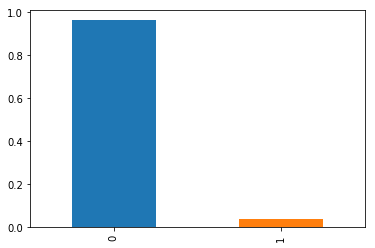

In [11]:
data_train.TARGET.value_counts(normalize=1).plot.bar()

In [12]:
#классы не сбалансированы

In [13]:
data_test.head(10)

ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   2     2     32                 0.0                     0.00   
1   5     2     35                 0.0                     0.00   
2   6     2     23                 0.0                     0.00   
3   7     2     24                 0.0                     0.00   
4   9     2     23                 0.0                     0.00   
5  11     2     43                 0.0                     0.00   
6  12     2     39               495.0                  2334.42   
7  15     2     29                 0.0                     0.00   
8  16     2     53                 0.0                     0.00   
9  17     2     37                 0.0                     0.00   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                     0.00                      0.0                      0.0   
1                     0.00                      0.0                      0.0   
2                     0.00                      0.0                      0.0   
3                     0.00                      0.0                      0.0   
4                     0.00                      0.0                      0.0   
5                     0.00                      0.0                      0.0   
6                  4815.42                      0.0                      0.0   
7                     0.00                      0.0                      0.0   
8                     0.00                      0.0                      0.0   
9                     0.00                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3    ...      \
0                      0.0                      0.0    ...       
1                      0.0                      0.0    ...       
2                      0.0                      0.0    ...       
3                      0.0                      0.0    ...       
4                      0.0                      0.0    ...       
5                      0.0                      0.0    ...       
6                      0.0                      0.0    ...       
7                      0.0                      0.0    ...       
8                      0.0                      0.0    ...       
9                      0.0                      0.0    ...       

   saldo_medio_var29_ult3  saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
0                     0.0                     0.00                      0.0   
1                     0.0                     0.00                      0.0   
2                     0.0                     0.00                      0.0   
3                     0.0                     0.00                      0.0   
4                     0.0                     0.00                      0.0   
5                     0.0                     0.00                      0.0   
6                     0.0                  7077.51                      0.0   
7                     0.0                     0.00                      0.0   
8                     0.0                     0.00                      0.0   
9                     0.0                     0.00                      0.0   

   saldo_medio_var33_ult1  saldo_medio_var33_ult3  saldo_medio_var44_hace2  \
0                     0.0                    0.00                      0.0   
1                     0.0                    0.00                      0.0   
2                     0.0                    0.00                      0.0   
3                     0.0                    0.00                      0.0   
4                     0.0                    0.00                      0.0   
5                     0.0                    0.00                      0.0   
6                  7599.0                 7338.27                      0.0   
7                     0.0                    0.00                      0.0   
8                     0.0                    0.00                      0.0   
9      

In [10]:
data_test.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Data columns (total 370 columns):
ID                               75818 non-null int64
var3                             75818 non-null int64
var15                            75818 non-null int64
imp_ent_var16_ult1               75818 non-null float64
imp_op_var39_comer_ult1          75818 non-null float64
imp_op_var39_comer_ult3          75818 non-null float64
imp_op_var40_comer_ult1          75818 non-null float64
imp_op_var40_comer_ult3          75818 non-null float64
imp_op_var40_efect_ult1          75818 non-null float64
imp_op_var40_efect_ult3          75818 non-null float64
imp_op_var40_ult1                75818 non-null float64
imp_op_var41_comer_ult1          75818 non-null float64
imp_op_var41_comer_ult3          75818 non-null float64
imp_op_var41_efect_ult1          75818 non-null float64
imp_op_var41_efect_ult3          75818 non-null float64
imp_op_var41_ult1                75818 non-null float64


In [ ]:
#попущенных значений нет

In [16]:
data_test.shape

(75818, 370)

In [11]:
data_test.describe()

ID           var3         var15  imp_ent_var16_ult1  \
count   75818.000000   75818.000000  75818.000000        75818.000000   
mean    75874.830581   -1579.955011     33.138832           83.164329   
std     43882.370827   39752.473358     12.932000         1694.873886   
min         2.000000 -999999.000000      5.000000            0.000000   
25%     37840.250000       2.000000     23.000000            0.000000   
50%     75810.000000       2.000000     27.000000            0.000000   
75%    113996.500000       2.000000     39.000000            0.000000   
max    151837.000000     238.000000    105.000000       240000.000000   

       imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
count             75818.000000             75818.000000   
mean                 74.312894               123.136448   
std                 364.211245               606.431562   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               21093.960000             47943.960000   

       imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
count             75818.000000             75818.000000   
mean                  4.578517                 7.666855   
std                 133.383326               239.701416   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               21093.960000             47943.960000   

       imp_op_var40_efect_ult1  imp_op_var40_efect_ult3      ...       \
count             75818.000000             75818.000000      ...        
mean                  0.470645                 0.672444      ...        
std                  34.028605                42.336668      ...        
min                   0.000000                 0.000000      ...        
25%                   0.000000                 0.000000      ...        
50%                   0.000000                 0.000000      ...        
75%                   0.000000                 0.000000      ...        
max                6600.000000              6600.000000      ...        

       saldo_medio_var29_ult3  saldo_medio_var33_hace2  \
count            75818.000000             75818.000000   
mean                 0.160595                12.438559   
std                 32.441677               958.651673   
min                  0.000000                 0.000000   
25%                  0.000000                 0.000000   
50%                  0.000000                 0.000000   
75%                  0.000000                 0.000000   
max               8030.160000            146605.320000   

       saldo_medio_var33_hace3  saldo_medio_var33_ult1  \
count             75818.000000            75818.000000   
mean                  1.327408               17.469991   
std                 170.449935             1252.618781   
min                   0.000000               -0.600000   
25%                   0.000000                0.000000   
50%                   0.000000                0.000000   
75%                   0.000000                0.000000   
max               40080.600000           162355.800000   

       saldo_medio_var33_ult3  saldo_medio_var44_hace2  \
count            75818.000000             75818.000000   
mean                12.674349                63.597839   
std                895.165516              3754.668954   
min                 -0.600000                 0.000000   
25%                  0.000000                 0.000000   
50%                  0.000000                 0.000000   
75%                  0.000000                 0.000000   
max             138054.960000            453893.400000   

       saldo_medio_var44_hace3  saldo_medio_var44_ult1  \
count      

In [12]:
sample_submission.head()

ID  TARGET
0   2       0
1   5       0
2   6       0
3   7       0
4   9       0

In [13]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Data columns (total 2 columns):
ID        75818 non-null int64
TARGET    75818 non-null int64
dtypes: int64(2)
memory usage: 1.2 MB


In [14]:
sample_submission.describe()

ID   TARGET
count   75818.000000  75818.0
mean    75874.830581      0.0
std     43882.370827      0.0
min         2.000000      0.0
25%     37840.250000      0.0
50%     75810.000000      0.0
75%    113996.500000      0.0
max    151837.000000      0.0

In [15]:
sample_submission["TARGET"].value_counts()

0    75818
Name: TARGET, dtype: int64

In [16]:
sample_submission["TARGET"].describe()

count    75818.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: TARGET, dtype: float64

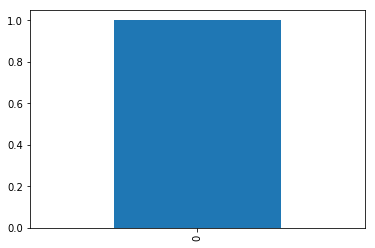

In [17]:
sample_submission.TARGET.value_counts(normalize=1).plot.bar()

In [ ]:
###уменьшение размерности датасета

In [19]:
#поищем пустые колонки
data_train['ind_var2_0'].describe()

count    76020.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: ind_var2_0, dtype: float64

In [21]:
# Посмотрим много ли таких
len(data_train.describe().loc['std'][data_train.describe().loc['std']==0])

34

In [23]:
const=data_train.describe().loc['std'][data_train.describe().loc['std']==0].index.tolist()
len(const)

34

In [25]:
#избавимся от пустых колонок
print('Shape before drop-->',data_train.shape)
data_train.drop(const, inplace=True, axis=1)

print('Shape after drop-->',data_train.shape)

Shape before drop--> (76020, 371)
Shape after drop--> (76020, 337)


In [27]:
print(data_train['num_aport_var33_ult1'].value_counts()/len(data_train))
print(data_train['num_var29'].value_counts()/len(data_train))
print(data_train['num_venta_var44_ult1'].value_counts()/len(data_train))

0    0.999908
3    0.000079
6    0.000013
Name: num_aport_var33_ult1, dtype: float64
0    0.999974
3    0.000026
Name: num_var29, dtype: float64
0     0.999421
3     0.000316
6     0.000092
9     0.000053
12    0.000039
27    0.000026
21    0.000026
39    0.000013
15    0.000013
Name: num_venta_var44_ult1, dtype: float64


In [ ]:
#есть данные где на одно значение прихоится более 99% наблюдений

In [31]:
quasiModel=VarianceThreshold(threshold=0.01) #It will search for the features having 99% of same value in all samples.
quasiModel.fit(data_train)

VarianceThreshold(threshold=0.01)

In [32]:
quasiArr=quasiModel.get_support()
quasiArr

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True, False,  True, False, False, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,

In [33]:
import collections
collections.Counter(quasiArr)

Counter({True: 274, False: 63})

In [34]:
len(data_train.columns[quasiArr])

274

In [35]:
quasiCols=[col for col in data_train.columns if col not in data_train.columns[quasiArr]]
len(quasiCols)

63

In [36]:
print('Shape before drop-->',data_train.shape)
data_train.drop(columns=quasiCols,axis=1,inplace=True)

print('Shape after drop-->',data_train.shape)

Shape before drop--> (76020, 337)
Shape after drop--> (76020, 274)


4. Провести стратегию Feature Selection (попробовать как минимум два различных подхода)

In [37]:
data_train[['ind_var26_0', 'ind_var26']].describe()

ind_var26_0     ind_var26
count  76020.000000  76020.000000
mean       0.024638      0.024638
std        0.155021      0.155021
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        0.000000      0.000000
max        1.000000      1.000000

In [38]:
#поищем одинаковые переменные

In [39]:
data_train[['ind_var26_0', 'ind_var26']].corr()

ind_var26_0  ind_var26
ind_var26_0          1.0        1.0
ind_var26            1.0        1.0

In [40]:
import itertools

In [43]:
same_to_drop=[]
for x,y in itertools.combinations(data_train.columns, 2):
    if data_train[[x,y]].corr().iloc[:1,1].values==1:
        same_to_drop.append([x,y])
    #break
len(same_to_drop)

19

In [44]:
same_to_drop

[['ind_var26_0', 'ind_var26'],
 ['ind_var25_0', 'ind_var25'],
 ['ind_var37_0', 'ind_var37'],
 ['num_var26_0', 'num_var26'],
 ['num_var25_0', 'num_var25'],
 ['num_var32_0', 'num_var32'],
 ['num_var37_0', 'num_var37'],
 ['num_var40', 'num_var39'],
 ['saldo_var6', 'saldo_var29'],
 ['saldo_var13_medio', 'saldo_medio_var13_medio_ult1'],
 ['delta_imp_aport_var17_1y3', 'delta_num_aport_var17_1y3'],
 ['delta_imp_aport_var33_1y3', 'delta_num_aport_var33_1y3'],
 ['delta_imp_reemb_var13_1y3', 'delta_num_reemb_var13_1y3'],
 ['delta_imp_reemb_var17_1y3', 'delta_num_reemb_var17_1y3'],
 ['delta_imp_reemb_var33_1y3', 'delta_num_reemb_var33_1y3'],
 ['delta_imp_trasp_var17_in_1y3', 'delta_num_trasp_var17_in_1y3'],
 ['delta_imp_trasp_var17_out_1y3', 'delta_num_trasp_var17_out_1y3'],
 ['delta_imp_trasp_var33_in_1y3', 'delta_num_trasp_var33_in_1y3'],
 ['delta_imp_trasp_var33_out_1y3', 'delta_num_trasp_var33_out_1y3']]

In [45]:
print('Shape before drop-->',data_train.shape)
data_train.drop(array(same_to_drop)[:,1], inplace=True, axis=1)

print('Shape after drop-->',data_train.shape)

Shape before drop--> (76020, 274)
Shape after drop--> (76020, 255)


In [46]:
data_train.describe()

ID           var3         var15  imp_ent_var16_ult1  \
count   76020.000000   76020.000000  76020.000000        76020.000000   
mean    75964.050723   -1523.199277     33.212865           86.208265   
std     43781.947379   39033.462364     12.956486         1614.757313   
min         1.000000 -999999.000000      5.000000            0.000000   
25%     38104.750000       2.000000     23.000000            0.000000   
50%     76043.000000       2.000000     28.000000            0.000000   
75%    113748.750000       2.000000     40.000000            0.000000   
max    151838.000000     238.000000    105.000000       210000.000000   

       imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
count             76020.000000             76020.000000   
mean                 72.363067               119.529632   
std                 339.315831               546.266294   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               12888.030000             21024.810000   

       imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
count             76020.000000             76020.000000   
mean                  3.559130                 6.472698   
std                  93.155749               153.737066   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max                8237.820000             11073.570000   

       imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  imp_op_var40_ult1  \
count             76020.000000             76020.000000       76020.000000   
mean                  0.412946                 0.567352           3.160715   
std                  30.604864                36.513513          95.268204   
min                   0.000000                 0.000000           0.000000   
25%                   0.000000                 0.000000           0.000000   
50%                   0.000000                 0.000000           0.000000   
75%                   0.000000                 0.000000           0.000000   
max                6600.000000              6600.000000        8237.820000   

       imp_op_var41_comer_ult1  imp_op_var41_comer_ult3  \
count             76020.000000             76020.000000   
mean                 68.803937               113.056934   
std                 319.605516               512.154823   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               12888.030000             16566.810000   

       imp_op_var41_efect_ult1  imp_op_var41_efect_ult3  imp_op_var41_ult1  \
count             76020.000000             76020.000000       76020.000000   
mean                 68.205140               113.225058         137.242763   
std                 531.897917               950.086398         697.712596   
min                   0.000000                 0.000000           0.000000   
25%                   0.000000                 0.000000           0.000000   
50%                   0.000000                 0.000000           0.000000   
75%                   0.000000                 0.000000           0.000000   
max               45990.000000            131100.000000       47598.090000   

       imp_op_var39_efect_ult1  imp_op_var39_efect_ult3  imp_op_var39_ult1  \
count             76020.000000             76020.000000       76020.000000   
mean                 68.618087               113.792410         140.403479   
std                 535.473750               953.578624         712.767240   
min                   0.000000                

In [47]:
data_train['var3'].value_counts().sort_values(ascending=False).index[0]

2

In [49]:
data_train['var3']=data_train['var3'].apply(
            lambda x: data_train['var3'].value_counts().sort_values(ascending=False).index[0] if x==-999999  else  x )

In [50]:
data_train.head()

ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   
3   8     2     37                 0.0                    195.0   
4  10     2     39                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  imp_op_var40_ult1  \
0                      0.0                      0.0                0.0   
1                      0.0                      0.0                0.0   
2                      0.0                      0.0                0.0   
3                      0.0                      0.0                0.0   
4                      0.0                      0.0                0.0   

   imp_op_var41_comer_ult1  imp_op_var41_comer_ult3  imp_op_var41_efect_ult1  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                    195.0                      0.0   
4                      0.0                      0.0                      0.0   

   imp_op_var41_efect_ult3  imp_op_var41_ult1  imp_op_var39_efect_ult1  \
0                      0.0                0.0                      0.0   
1                      0.0                0.0                      0.0   
2                      0.0                0.0                      0.0   
3                      0.0              195.0                      0.0   
4                      0.0                0.0                      0.0   

   imp_op_var39_efect_ult3  imp_op_var39_ult1  imp_sal_var16_ult1  ind_var1_0  \
0                      0.0                0.0                 0.0           0   
1                      0.0                0.0                 0.0           0   
2                      0.0                0.0                 0.0           0   
3                      0.0              195.0                 0.0           0   
4                      0.0                0.0                 0.0           0   

   ind_var5_0  ind_var5  ind_var8_0  ind_var8  ind_var12_0  ind_var12  \
0           1         0           0         0            0          0   
1           1         0           0         0            0          0   
2           1         1           0         0            0          0   
3           1         1           0         0            0          0   
4           1         0           0         0            1          1   

   ind_var13_0  ind_var13_corto_0  ind_var13_corto  ind_var13_largo_0  \
0            0                  0                0                  0   
1            1                  1                1                  0   
2            0                  0                0                  0   
3            0                  0                0                  0   
4            0                  0                0                  0   

   ind_var13  ind_var14_0  ind_var24_0  ind_var24  ind_var25_cte  ind_var26_0  \
0          0            0            0          0              0            0   
1          1            0            0          0              0            0   
2          0            0            0          0              0            0   
3          0            0            0          0          

In [51]:
features = data_train.columns[1:-1]
features

Index(['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3', 'imp_op_var40_ult1',
       ...
       'saldo_medio_var29_ult3', 'saldo_medio_var33_hace2',
       'saldo_medio_var33_hace3', 'saldo_medio_var33_ult1',
       'saldo_medio_var33_ult3', 'saldo_medio_var44_hace2',
       'saldo_medio_var44_hace3', 'saldo_medio_var44_ult1',
       'saldo_medio_var44_ult3', 'var38'],
      dtype='object', length=253)

In [52]:
X=data_train[features]
y=data_train.TARGET

In [53]:
X.shape

(76020, 253)

3. Провести анализ корреляции переменных, отобразить взаимосвязи между переменными

In [55]:
corr_matrix = data_train.corr()
corr_matrix

ID      var3     var15  \
ID                             1.000000 -0.002327 -0.002135   
var3                          -0.002327  1.000000  0.124320   
var15                         -0.002135  0.124320  1.000000   
imp_ent_var16_ult1            -0.003111  0.000815  0.043722   
imp_op_var39_comer_ult1       -0.001436  0.103668  0.094762   
imp_op_var39_comer_ult3       -0.004131  0.174162  0.101177   
imp_op_var40_comer_ult1       -0.007277  0.098880  0.042754   
imp_op_var40_comer_ult3       -0.006302  0.184095  0.048512   
imp_op_var40_efect_ult1       -0.006700  0.008942  0.008805   
imp_op_var40_efect_ult3       -0.006698  0.015110  0.009678   
imp_op_var40_ult1             -0.008326  0.058673  0.035884   
imp_op_var41_comer_ult1        0.000596  0.081241  0.088145   
imp_op_var41_comer_ult3       -0.002515  0.130500  0.093354   
imp_op_var41_efect_ult1       -0.001869  0.036389  0.085281   
imp_op_var41_efect_ult3       -0.002927  0.056973  0.074686   
imp_op_var41_ult1             -0.000303  0.031331  0.104643   
imp_op_var39_efect_ult1       -0.002239  0.036657  0.085215   
imp_op_var39_efect_ult3       -0.003173  0.057343  0.074783   
imp_op_var39_ult1             -0.001409  0.038512  0.107229   
imp_sal_var16_ult1            -0.006793 -0.000677  0.013525   
ind_var1_0                    -0.001022  0.110992  0.106042   
ind_var5_0                     0.002002 -0.210649 -0.112228   
ind_var5                       0.003493 -0.056026 -0.098936   
ind_var8_0                    -0.003050  0.010764  0.111776   
ind_var8                      -0.003880  0.013177  0.101437   
ind_var12_0                   -0.002967  0.000146  0.262891   
ind_var12                     -0.006262  0.006128  0.219815   
ind_var13_0                    0.000466  0.034795  0.300081   
ind_var13_corto_0              0.000439 -0.010774  0.243894   
ind_var13_corto               -0.000157 -0.010398  0.241273   
...                                 ...       ...       ...   
saldo_medio_var12_ult1        -0.005683  0.022624  0.185961   
saldo_medio_var12_ult3        -0.005480  0.023084  0.186720   
saldo_medio_var13_corto_hace2 -0.002670 -0.003805  0.188661   
saldo_medio_var13_corto_hace3  0.000061 -0.001490  0.106964   
saldo_medio_var13_corto_ult1  -0.001763 -0.005598  0.210294   
saldo_medio_var13_corto_ult3  -0.001883 -0.005949  0.207802   
saldo_medio_var13_largo_hace2  0.003373  0.081214  0.122017   
saldo_medio_var13_largo_hace3  0.000935  0.131745  0.072549   
saldo_medio_var13_largo_ult1   0.002975  0.065832  0.121317   
saldo_medio_var13_largo_ult3   0.003911  0.073188  0.122041   
saldo_medio_var13_medio_hace2  0.000066 -0.000384  0.002854   
saldo_medio_var13_medio_ult3  -0.001336 -0.000356  0.002339   
saldo_medio_var17_hace2       -0.003024  0.008426  0.015796   
saldo_medio_var17_hace3       -0.003714  0.004057  0.011859   
saldo_medio_var17_ult1        -0.002258  0.019614  0.020383   
saldo_medio_var17_ult3        -0.002629  0.017337  0.019886   
saldo_medio_var29_hace2        0.000693 -0.000368  0.007891   
saldo_medio_var29_hace3        0.000137  0.003180 -0.002859   
saldo_medio_var29_ult1        -0.005999 -0.000370  0.010679   
saldo_medio_var29_ult3        -0.007631 -0.000444  0.011623   
saldo_medio_var33_hace2        0.001986  0.147544  0.029358   
saldo_medio_var33_hace3        0.003771  0.094411  0.017264   
saldo_medio_var33_ult1        -0.001521  0.118486  0.028504   
saldo_medio_var33_ult3        -0.001216  0.128381  0.029176   
saldo_medio_var44_hace2       -0.003772  0.021088  0.029180   
saldo_medio_var44_hace3       -0.003674  0.066479  0.018884   
saldo_medio_var44_ult1        -0.000856  0.010151  0.032833   
saldo_medio_var44_ult3         0.000297  0.010551  0.033597   
var38                         -0.005687  0.013232  0.006497   
TARGET                         0.003148 -0.010565  0.101322   

                               imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
ID                                      -0.003111   

In [54]:
corr = data_train.corr()

In [56]:
abs(corr.TARGET).sort_values(ascending=False)

TARGET                           1.000000
ind_var30                        0.149811
num_meses_var5_ult3              0.148253
num_var30                        0.138289
num_var42                        0.135693
ind_var5                         0.135349
num_var5                         0.134095
var36                            0.102919
var15                            0.101322
num_var4                         0.080194
num_var35                        0.076872
ind_var8_0                       0.046665
num_var8_0                       0.046622
ind_var13                        0.039612
ind_var13_0                      0.039471
num_var13                        0.038400
ind_var12_0                      0.038215
num_var13_0                      0.038045
saldo_var30                      0.037092
ind_var39_0                      0.035045
ind_var13_corto                  0.034438
num_var13_corto                  0.034432
num_meses_var13_corto_ult3       0.034367
ind_var13_corto_0                0

In [59]:
to_plot=abs(corr.TARGET).sort_values(ascending=False).index.tolist()[1:80]
len(to_plot)

79

In [60]:
corr_to_plot = data_train.loc[:, to_plot].corr()

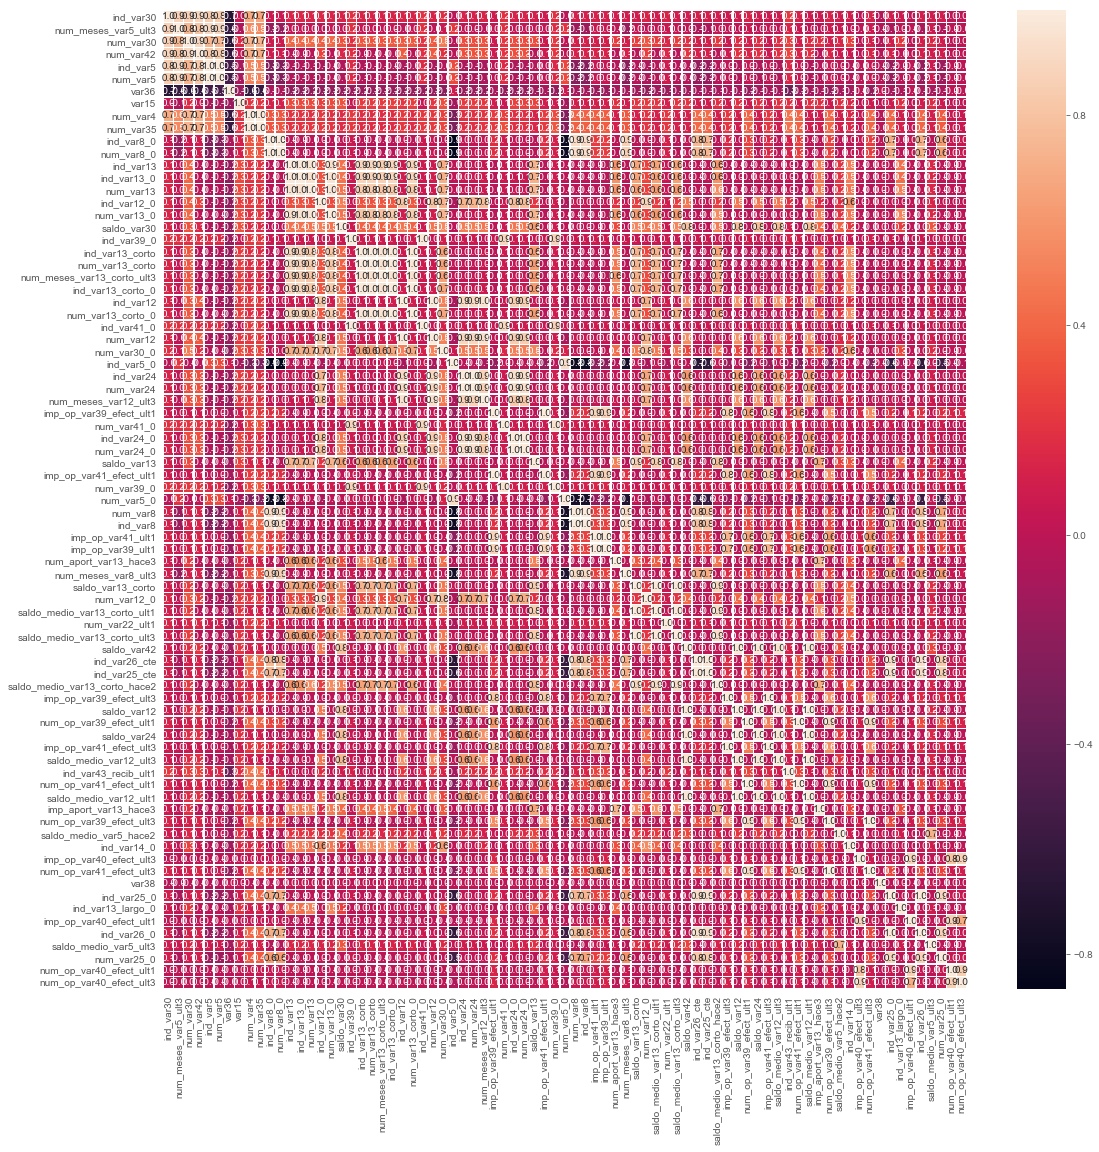

In [61]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(corr_to_plot, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

5. Шкалировать данные несколькими способами (нормализация, стандартизация). Какой подход лучше?

In [67]:
#Нормировка значений
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [68]:
columns = data_train.columns

In [69]:
data_scaled = scaler.transform(data_train)
data_scaled = pd.DataFrame(data_scaled, columns=columns)
data_scaled.head(10)

ID      var3     var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0 -1.735043 -0.075835 -0.788249           -0.053388                -0.213263   
1 -1.734997 -0.075835  0.060753           -0.053388                -0.213263   
2 -1.734974 -0.075835 -0.788249           -0.053388                -0.213263   
3 -1.734883 -0.075835  0.292298           -0.053388                 0.361427   
4 -1.734837 -0.075835  0.446662           -0.053388                -0.213263   
5 -1.734769 -0.075835 -0.788249           -0.053388                -0.213263   
6 -1.734746 -0.075835 -0.479521           -0.053388                -0.213263   
7 -1.734654 -0.075835 -0.556703           -0.053388                -0.213263   
8 -1.734609 -0.075835  0.909754           -0.053388                -0.213263   
9 -1.734540 -0.075835 -0.633885           -0.053388                -0.213263   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                -0.218813                -0.038206                -0.042103   
1                -0.218813                -0.038206                -0.042103   
2                -0.218813                -0.038206                -0.042103   
3                 0.138158                -0.038206                -0.042103   
4                -0.218813                -0.038206                -0.042103   
5                -0.218813                -0.038206                -0.042103   
6                -0.218813                -0.038206                -0.042103   
7                -0.218813                -0.038206                -0.042103   
8                -0.218813                -0.038206                -0.042103   
9                -0.218813                -0.038206                -0.042103   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  imp_op_var40_ult1  \
0                -0.013493                -0.015538          -0.033177   
1                -0.013493                -0.015538          -0.033177   
2                -0.013493                -0.015538          -0.033177   
3                -0.013493                -0.015538          -0.033177   
4                -0.013493                -0.015538          -0.033177   
5                -0.013493                -0.015538          -0.033177   
6                -0.013493                -0.015538          -0.033177   
7                -0.013493                -0.015538          -0.033177   
8                -0.013493                -0.015538          -0.033177   
9                -0.013493                -0.015538          -0.033177   

   imp_op_var41_comer_ult1  imp_op_var41_comer_ult3  imp_op_var41_efect_ult1  \
0                -0.215279                -0.220749                -0.128231   
1                -0.215279                -0.220749                -0.128231   
2                -0.215279                -0.220749                -0.128231   
3                 0.394852                 0.159998                -0.128231   
4                -0.215279                -0.220749                -0.128231   
5                -0.215279                -0.220749                -0.128231   
6                -0.215279                -0.220749                -0.128231   
7                -0.215279                -0.220749                -0.128231   
8                -0.215279                -0.220749                -0.128231   
9                -0.215279                -0.220749                -0.128231   

   imp_op_var41_efect_ult3  imp_op_var41_ult1  imp_op_var39_efect_ult1  \
0                -0.119174          -0.196705                -0.128145   
1                -0.119174          -0.196705                -0.128145   
2                -0.119174          -0.196705                -0.128145   
3                -0.119174           0.082781                -0.128145   
4                -0.119174          -0.196705                -0.128145   
5                -0.119174          -0.196705                -0.128145   
6                -0.119174       

In [70]:
corr_matrix = data_scaled.corr()
corr_matrix

ID      var3     var15  \
ID                             1.000000 -0.002327 -0.002135   
var3                          -0.002327  1.000000  0.124320   
var15                         -0.002135  0.124320  1.000000   
imp_ent_var16_ult1            -0.003111  0.000815  0.043722   
imp_op_var39_comer_ult1       -0.001436  0.103668  0.094762   
imp_op_var39_comer_ult3       -0.004131  0.174162  0.101177   
imp_op_var40_comer_ult1       -0.007277  0.098880  0.042754   
imp_op_var40_comer_ult3       -0.006302  0.184095  0.048512   
imp_op_var40_efect_ult1       -0.006700  0.008942  0.008805   
imp_op_var40_efect_ult3       -0.006698  0.015110  0.009678   
imp_op_var40_ult1             -0.008326  0.058673  0.035884   
imp_op_var41_comer_ult1        0.000596  0.081241  0.088145   
imp_op_var41_comer_ult3       -0.002515  0.130500  0.093354   
imp_op_var41_efect_ult1       -0.001869  0.036389  0.085281   
imp_op_var41_efect_ult3       -0.002927  0.056973  0.074686   
imp_op_var41_ult1             -0.000303  0.031331  0.104643   
imp_op_var39_efect_ult1       -0.002239  0.036657  0.085215   
imp_op_var39_efect_ult3       -0.003173  0.057343  0.074783   
imp_op_var39_ult1             -0.001409  0.038512  0.107229   
imp_sal_var16_ult1            -0.006793 -0.000677  0.013525   
ind_var1_0                    -0.001022  0.110992  0.106042   
ind_var5_0                     0.002002 -0.210649 -0.112228   
ind_var5                       0.003493 -0.056026 -0.098936   
ind_var8_0                    -0.003050  0.010764  0.111776   
ind_var8                      -0.003880  0.013177  0.101437   
ind_var12_0                   -0.002967  0.000146  0.262891   
ind_var12                     -0.006262  0.006128  0.219815   
ind_var13_0                    0.000466  0.034795  0.300081   
ind_var13_corto_0              0.000439 -0.010774  0.243894   
ind_var13_corto               -0.000157 -0.010398  0.241273   
...                                 ...       ...       ...   
saldo_medio_var12_ult1        -0.005683  0.022624  0.185961   
saldo_medio_var12_ult3        -0.005480  0.023084  0.186720   
saldo_medio_var13_corto_hace2 -0.002670 -0.003805  0.188661   
saldo_medio_var13_corto_hace3  0.000061 -0.001490  0.106964   
saldo_medio_var13_corto_ult1  -0.001763 -0.005598  0.210294   
saldo_medio_var13_corto_ult3  -0.001883 -0.005949  0.207802   
saldo_medio_var13_largo_hace2  0.003373  0.081214  0.122017   
saldo_medio_var13_largo_hace3  0.000935  0.131745  0.072549   
saldo_medio_var13_largo_ult1   0.002975  0.065832  0.121317   
saldo_medio_var13_largo_ult3   0.003911  0.073188  0.122041   
saldo_medio_var13_medio_hace2  0.000066 -0.000384  0.002854   
saldo_medio_var13_medio_ult3  -0.001336 -0.000356  0.002339   
saldo_medio_var17_hace2       -0.003024  0.008426  0.015796   
saldo_medio_var17_hace3       -0.003714  0.004057  0.011859   
saldo_medio_var17_ult1        -0.002258  0.019614  0.020383   
saldo_medio_var17_ult3        -0.002629  0.017337  0.019886   
saldo_medio_var29_hace2        0.000693 -0.000368  0.007891   
saldo_medio_var29_hace3        0.000137  0.003180 -0.002859   
saldo_medio_var29_ult1        -0.005999 -0.000370  0.010679   
saldo_medio_var29_ult3        -0.007631 -0.000444  0.011623   
saldo_medio_var33_hace2        0.001986  0.147544  0.029358   
saldo_medio_var33_hace3        0.003771  0.094411  0.017264   
saldo_medio_var33_ult1        -0.001521  0.118486  0.028504   
saldo_medio_var33_ult3        -0.001216  0.128381  0.029176   
saldo_medio_var44_hace2       -0.003772  0.021088  0.029180   
saldo_medio_var44_hace3       -0.003674  0.066479  0.018884   
saldo_medio_var44_ult1        -0.000856  0.010151  0.032833   
saldo_medio_var44_ult3         0.000297  0.010551  0.033597   
var38                         -0.005687  0.013232  0.006497   
TARGET                         0.003148 -0.010565  0.101322   

                               imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
ID                                      -0.003111   

In [ ]:
#2

In [71]:
X_norm = pd.DataFrame(normalize(X, axis=0),columns=X.columns)
X_train_norm, X_test_norm ,y_train, y_test = train_test_split(X_norm, y, random_state=42, test_size=.3)

In [72]:
st = StandardScaler()
X_st = pd.DataFrame(st.fit_transform(X),columns=X.columns)
X_train_st, X_test_st ,y_train, y_test = train_test_split(X_st, y, random_state=42, test_size=.3)

In [73]:
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)
X_minmax=pd.DataFrame(X_minmax,columns=X.columns)
X_train_minmax, X_test_minmax ,y_train, y_test = train_test_split(X_minmax, y, random_state=42, test_size=.3)

In [74]:
results=pd.DataFrame(columns=['model','mean_cv_train_score','test_score'])

In [75]:
Xes=['norm','st','minmax']

In [76]:
X_test_st[features].columns

Index(['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3', 'imp_op_var40_ult1',
       ...
       'saldo_medio_var29_ult3', 'saldo_medio_var33_hace2',
       'saldo_medio_var33_hace3', 'saldo_medio_var33_ult1',
       'saldo_medio_var33_ult3', 'saldo_medio_var44_hace2',
       'saldo_medio_var44_hace3', 'saldo_medio_var44_ult1',
       'saldo_medio_var44_ult3', 'var38'],
      dtype='object', length=253)

## PCA

Метод главных компонент (PCA) позволяет уменьшить размерность данных, потеряв наименьшее количество информации. 

In [78]:
Xes=['norm','st','minmax']

Text(0, 0.5, 'explained_variance_ratio_')

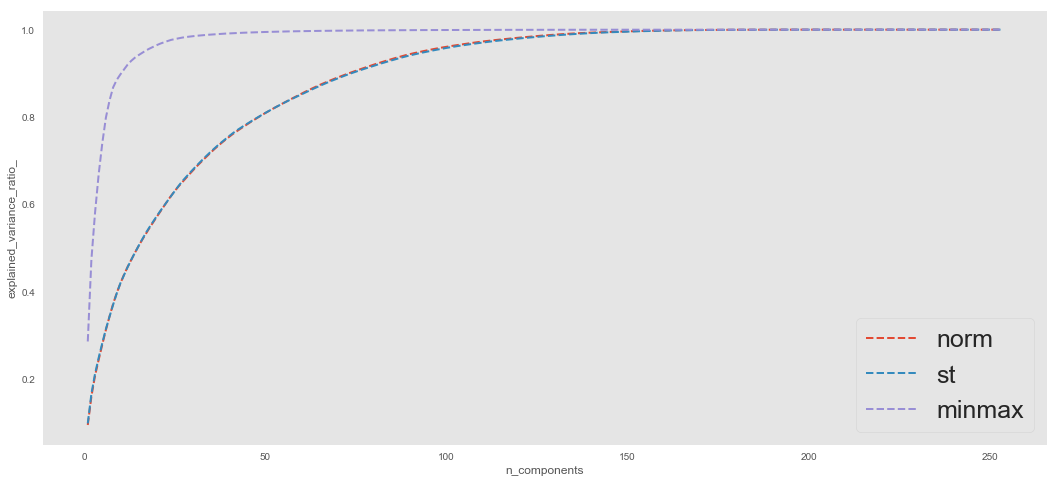

In [79]:
plt.figure(figsize=(18, 8))

for Xes in Xes:
    #pca_norm = PCA().fit(X_norm)
    globals()['pca_'+Xes] =PCA().fit(eval('X_'+Xes))   
    globals()['cum_evr_'+Xes]=np.cumsum(globals()['pca_'+Xes].explained_variance_ratio_)
    #cum_evr_norm = np.cumsum(pca_norm.explained_variance_ratio_)
    #xs_norm = np.arange(cum_evr_norm.size) + 1
    globals()['xs_'+Xes]=np.arange(globals()['cum_evr_'+Xes].size) + 1
    #plt.plot( fpr, tpr , label= "Model: {},  AUC={:.6f}".format( 'grid_SVC',AUC),linestyle='--' )
    plt.plot(globals()['xs_'+Xes], globals()['cum_evr_'+Xes], label=Xes,linewidth=2,linestyle='--' )
plt.grid()
plt.legend( loc = 4, prop={'size': 25})
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [80]:
components = 150
pca = PCA(n_components=components).fit(X_st)
X_PCA_st=pd.DataFrame(PCA(n_components=components).fit_transform(X_st))
sum(pca.explained_variance_ratio_)

0.995413931787161

In [81]:
components = 150
pca = PCA(n_components=components).fit(X_norm)
X_PCA_norm=pd.DataFrame(PCA(n_components=components).fit_transform(X_norm))
sum(pca.explained_variance_ratio_)

0.9961125847642606

In [82]:
components = 50
pca = PCA(n_components=components).fit(X_minmax)
X_PCA_minmax=pd.DataFrame(PCA(n_components=components).fit_transform(X_minmax))
sum(pca.explained_variance_ratio_)

0.9946420568759977

In [83]:
X_train_PCA_minmax,X_test_PCA_minmax, y_train, y_test = train_test_split(X_PCA_minmax ,y, test_size=0.3,random_state=42)

In [84]:
X_train_PCA_norm, X_test_PCA_norm, y_train, y_test = train_test_split(X_PCA_norm ,y, test_size=0.3,random_state=42)

In [85]:
X_train_PCA_st, X_test_PCA_st, y_train, y_test = train_test_split(X_PCA_st ,y, test_size=0.3,random_state=42)

In [ ]:
%%time
Xes=['norm','st','minmax']
for Xes in Xes:  
    globals()['xgb_PCA_'+Xes] = xgboost.XGBClassifier(n_jobs=-1)
    eval('xgb_PCA_'+Xes).fit(eval('X_train_PCA_'+Xes), y_train)
    globals()['cv_PCA_'+Xes]=cross_val_score(xgboost.XGBClassifier(n_jobs=-1), eval('X_train_PCA_'+Xes), y_train, scoring='roc_auc',cv=10,n_jobs=-1)
    results = results.append({'model' : 'cv_PCA_'+Xes , 'mean_cv_train_score' : eval('cv_PCA_'+Xes).mean(),'test_score':metrics.roc_auc_score(y_test, eval('xgb_PCA_'+Xes).predict_proba(eval('X_test_PCA_'+Xes))[:, 1])} , ignore_index=True)
    print('cv_PCA_'+Xes)
    print("__________________________________________________")

cv_PCA_norm
__________________________________________________


In [ ]:
#не особо могает PCA
print(confusion_matrix(xgb_PCA_minmax.predict(X_test_PCA_minmax), y_test))

In [ ]:
results

6. Попробовать стратегию oversamling и сравнить ее с неизмененной моделью

In [86]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomOverSampler(random_state=0)
ros.fit(X_train_st, y_train)
X_oversampled, y_overesampled = ros.fit_resample(X_train_st[rfecv_with_pca_components_st_best_featurs], y_train)

NameError: name 'rfecv_with_pca_components_st_best_featurs' is not defined

7. Попробовать стратегию undersampling и сравнить ее с неизмененной моделью

8. Сделать кросс-валидацию тренировочных данных с использованием подхода K-fold (n_folds=10)

9. Решить задачу бинарной классификации и предсказать удовлетворение клиентов банка (переменная TARGET)

## Logistic Regression

In [87]:
from sklearn.linear_model import LogisticRegression

In [88]:
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 0.25, 0.5]
}

In [89]:
%%time
lr = LogisticRegression()
grid_lr = GridSearchCV(lr, lr_params, scoring='roc_auc', cv=10,n_jobs=-1)
grid_lr.fit(X_train, y_train)

NameError: name 'X_train' is not defined

10. Рассчитать Feature Importances для переменных модели

11. Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall

12. Построить Confusion Matrix для ваших результатов